In [1]:
import numpy as np
import pandas as pd
import copy
import time
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
def Boll_Band(DF,n=20):
    df=DF.copy()
    df["MB"]=df["Close"].rolling(n).mean()
    df["UB"]=df["MB"]+2*df["Close"].rolling(n).std(ddof=0)
    df["LB"]=df["MB"]-2*df["Close"].rolling(n).std(ddof=0)
    df["BB_Width"]=df["UB"]-df["LB"]
    return df[["MB","UB","LB","BB_Width"]]

In [3]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

In [4]:
# download the data
#ticker="SPY"
#spy=yf.download(ticker,period='60d',interval='5m')

In [5]:
spy=pd.read_csv("SPY_intraday.csv")
spy.index=pd.to_datetime(spy["Datetime"])
spy.drop("Datetime",axis=1,inplace=True)

In [6]:
spy

,Open,High,Low,Close,Volume,hours
Datetime,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday
...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday


In [7]:
spy["atr"]=ATR(spy,120)["ATR"]

In [8]:
Bollinger=Boll_Band(spy)
Bollinger

,MB,UB,LB,BB_Width
Datetime,,,,
2005-01-03 09:30:00,NaN,NaN,NaN,NaN
2005-01-03 09:35:00,NaN,NaN,NaN,NaN
2005-01-03 09:40:00,NaN,NaN,NaN,NaN
2005-01-03 09:45:00,NaN,NaN,NaN,NaN
2005-01-03 09:50:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-11-25 15:30:00,402.394920,402.617955,402.171885,0.446069
2022-11-25 15:35:00,402.406495,402.621828,402.191162,0.430667
2022-11-25 15:40:00,402.420495,402.587997,402.252993,0.335005


In [9]:
def gain_plot_no_stoploss():
    signal_list=[]
    signal=""
    return_list=[]
    for i in range(len(spy)):
        if spy.index[i].hour==15 and spy.index[i].minute==57:
            if signal=="Buy Call":
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
            elif signal=="Buy Put":
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
            elif signal=="":
                signal_list.append("")
                return_list.append(0)
        elif signal=="":
            if spy["Close"][i]>=Bollinger["UB"][i]:
                signal="Buy Call"
                signal_list.append(signal)
                cost=spy["Close"][i]
                return_list.append(0)
            elif spy["Close"][i]<=Bollinger["LB"][i]:
                signal="Buy Put"
                signal_list.append(signal)
                cost=spy["Close"][i]
                return_list.append(0)
            else:
                signal_list.append("")
                return_list.append(0)
        elif signal=="Buy Call":
            #sell signal
            if spy["Close"][i]<=Bollinger["MB"][i]:
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
            else:
                signal_list.append("")
                return_list.append(0)

        elif signal=="Buy Put":
            #sell signal
            if spy["Close"][i]>=Bollinger["MB"][i]:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
            else:
                signal_list.append("")
                return_list.append(0)

    spy["signal"]=signal_list
    spy["return"]=return_list
    spy['cum_return']=spy['return'].cumsum()
    return spy

<AxesSubplot:xlabel='Datetime'>

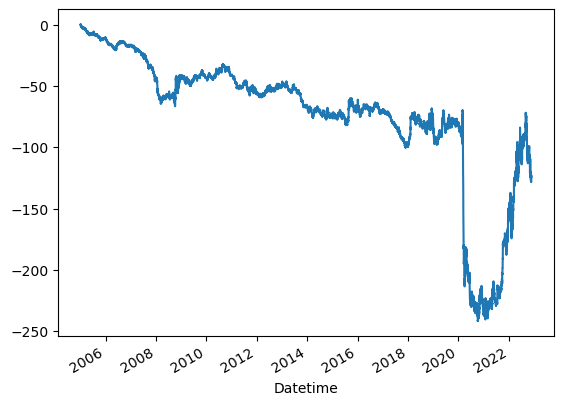

In [11]:
gain_plot_no_stoploss()["cum_return"].plot()

In [13]:
def gain_plot_combination_return():
    signal_list=[]
    signal=""
    return_list=[]
    stoploss_list=[]
    for i in range(len(spy)):
        if spy.index[i].hour==15 and spy.index[i].minute==55:
            if signal=="Buy Call":
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
                stoploss_list.append(0)
            elif signal=="Buy Put":
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
                stoploss_list.append(0)
            elif signal=="":
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(0)
        elif signal=="":
            if spy["Close"][i]>=Bollinger["UB"][i]:
                signal="Buy Call"
                signal_list.append(signal)
                cost=spy["Close"][i]
                stoploss=cost-spy["atr"][i]
                return_list.append(0)
                stoploss_list.append(stoploss)

            elif spy["Close"][i]<=Bollinger["LB"][i]:
                signal="Buy Put"
                signal_list.append(signal)
                cost=spy["Close"][i]
                stoploss=cost+spy["atr"][i]
                return_list.append(0)
                stoploss_list.append(stoploss)
            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(0)
        elif signal=="Buy Call":
            #sell signal
            if spy["Close"][i]<=Bollinger["MB"][i]:
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
                stoploss_list.append(0)
            elif spy["Close"][i]<stoploss:
                signal_list.append("Sell")
                signal=""
                return_list.append(spy["Close"][i]-cost)
                stoploss_list.append(stoploss)

            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(stoploss)

        elif signal=="Buy Put":
            #sell signal
            if spy["Close"][i]>=Bollinger["MB"][i]:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
                stoploss_list.append(0)
            elif spy["Close"][i]>stoploss:
                signal_list.append("Sell")
                signal=""
                return_list.append(cost-spy["Close"][i])
                stoploss_list.append(stoploss)
            else:
                signal_list.append("")
                return_list.append(0)
                stoploss_list.append(stoploss)

    spy["signal"]=signal_list
    spy["return"]=return_list
    spy["stop_loss"]=stoploss_list
    spy["return_dollar"]=spy["return"]*50
    spy['cum_return']=spy['return'].cumsum()
    spy["cum_return_dollar"]=spy["return_dollar"].cumsum()
    #spy['cum_return']=spy['return'].cumsum()
    return spy

In [14]:
gain_plot_combination_return()

,Open,High,Low,Close,Volume,hours,atr,signal,return,cum_return,stop_loss,return_dollar,cum_return_dollar
Datetime,,,,,,,,,,,,,
2005-01-03 09:30:00,87.0610,87.1326,87.0109,87.1111,1251700,intraday,NaN,,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:35:00,87.1111,87.2042,87.0968,87.1827,934900,intraday,NaN,,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:40:00,87.1541,87.1684,87.0968,87.1326,865500,intraday,NaN,,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:45:00,87.1326,87.1684,87.0753,87.0968,584700,intraday,NaN,,0.0,0.0000,0.0,0.0,0.00
2005-01-03 09:50:00,87.1326,87.1326,87.0180,87.0180,621600,intraday,NaN,,0.0,0.0000,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25 15:30:00,402.3600,402.3600,402.3600,402.3600,100,intraday,0.349082,,0.0,79.5234,0.0,0.0,3976.17
2022-11-25 15:35:00,402.4800,402.4800,402.4800,402.4800,900,intraday,0.344666,,0.0,79.5234,0.0,0.0,3976.17
2022-11-25 15:40:00,402.4800,402.4800,402.3900,402.3900,611,intraday,0.343332,,0.0,79.5234,0.0,0.0,3976.17


<AxesSubplot:xlabel='Datetime'>

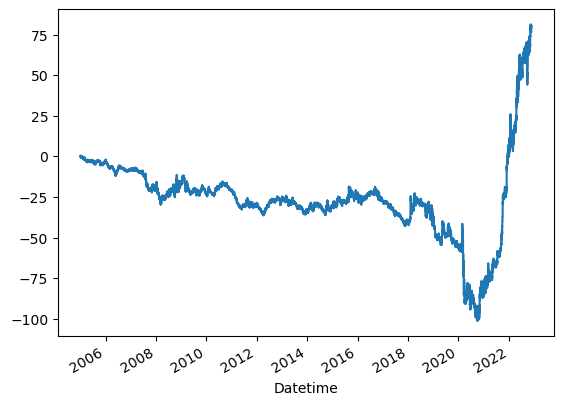

In [15]:
gain_plot_combination_return()['cum_return'].plot()

signal_list=[]
signal=""
return_list=[]
for i in range(len(spy)):
    if signal=="":
        if spy["Adj Close"][i]>=Bollinger["UB"][i]:
            signal="Buy Call"
            signal_list.append(signal)
            cost=spy["Adj Close"][i]
            return_list.append(0)
        elif spy["Adj Close"][i]<=Bollinger["LB"][i]:
            signal="Buy Put"
            signal_list.append(signal)
            cost=spy["Adj Close"][i]
            return_list.append(0)
        else:
            signal_list.append("")
            return_list.append(0)
    elif signal=="Buy Call":
        #sell signal
        if spy["Adj Close"][i]<=Bollinger["MB"][i]:
            signal_list.append("Sell")
            signal=""
            return_list.append(spy["Adj Close"][i]-cost)
        else:
            signal_list.append("")
            return_list.append(0)
            
    elif signal=="Buy Put":
        #sell signal
        if spy["Adj Close"][i]>=Bollinger["MB"][i]:
            signal_list.append("Sell")
            signal=""
            return_list.append(cost-spy["Adj Close"][i])
        else:
            signal_list.append("")
            return_list.append(0)

In [ ]:
len(signal_list)

In [ ]:
len(return_list)

In [ ]:
Bollinger

In [ ]:
Bollinger[["UB","MB","LB"]].plot()

In [ ]:
Bollinger[["UB","MB","LB"]][-140:].plot()

In [ ]:
import numpy as np
np.sum(Bollinger['return'])

In [ ]:
Bollinger['return'].sum()

In [ ]:
Bollinger['return'].cumsum()

In [ ]:
Bollinger["cum_return"]=Bollinger['return'].cumsum()

In [ ]:
Bollinger["Adj Close"]=spy["Adj Close"]

In [ ]:
Bollinger

In [ ]:
Bollinger["cum_return"].plot()

In [ ]:
Bollinger.to_csv('bollinger_strategy.csv')